In [1]:
# -*- coding: utf-8 -*-

"""
TFI Trotter Circuit Analysis with IBM Eagle Topology

This example demonstrates how to create a TFI (Transverse Field Ising) Trotter circuit
using the IBM Eagle topology with 127 qubits and analyze it with Pauli propagation.
"""

import numpy as np
from qiskit.quantum_info import Pauli, Statevector

# Custom package imports  
from pauli_propagation import PauliTerm, PauliPropagator
from pauli_propagation.utils import encode_pauli
from pauli_propagation.circuit_topologies import tfi_trotter_circuit

# Standard library imports
import logging
import time
import json
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# Qiskit imports
from qiskit import QuantumCircuit
from qiskit.quantum_info import Pauli, Statevector
from qiskit.circuit.library import UnitaryGate
from qiskit.synthesis import TwoQubitWeylDecomposition

# Custom package imports
from pauli_propagation import PauliTerm, PauliPropagator
from pauli_propagation.utils import encode_pauli, random_su4
from pauli_propagation.gates import QuantumGate
from pauli_propagation.monte_carlo import MonteCarlo
from pauli_propagation import staircasetopology2d_qc
from pauli_propagation.decomposition import su4_kak_reconstruct, su4_kak_decomp


# Configure logging
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)

In [2]:
nq = 127  # IBM Eagle has 127 qubits
nl = 4    # 5 layers

qc_tfi = tfi_trotter_circuit(nq, nl)

pauli_label = "I" * 64 + "Z" + "I" * 62  # 62 I's + 1 Z + 64 I's = 127 total
key = encode_pauli(Pauli(pauli_label))
init_term = PauliTerm(1.0, key, nq)

product_label = "0" * nq

prop_tfi = PauliPropagator(qc_tfi)

max_weight = 4

layers_tfi = prop_tfi.propagate(init_term, max_weight=max_weight, use_parallel=True)

exp_tfi = prop_tfi.expectation_pauli_sum(layers_tfi[-1], product_label)

print(exp_tfi)

# nl = 4, max_weight = none, 6min26s,0.22510709764831832 

Propagating, max weight: 4:   0%|          | 0/1084 [00:00<?, ?it/s]

0.2133883476483183


In [ ]:
# Define parameters
L_vals = [5,10,15,20,25] 
M = 10000 * 50
nq = 127
max_kk = 6

# Output directory for JSON files
out_dir_tfi = os.path.join("results", "tfi")
os.makedirs(out_dir_tfi, exist_ok=True)

for L in L_vals:
    # Build the TFI Trotter circuit & initial Pauli term 
    qc_tfi = tfi_trotter_circuit(nqubits=127,nlayers=L,
                                 start_with_ZZ=True,    
                                 rzz_theta = -np.pi/2,   
                                 rx_theta  = np.pi/3)     

    n = qc_tfi.num_qubits

    pauli_label = "I" * 64 + "Z" + "I" * 62
    key = encode_pauli(Pauli(pauli_label))
    init_term = PauliTerm(1.0, key, n)
    product_label = "0" * n
    prop_2d = PauliPropagator(qc_tfi)

    # Single Monte Carlo sampling run (shared across all k) 
    mc = MonteCarlo(qc_tfi)
    sample_file = os.path.join(out_dir_tfi, f"kicked_ising_samples_L{L}.pkl")
    
    # Use persistent sampling - will load existing samples if available
    _, _, last_weights, _ = mc.monte_carlo_samples(init_term=init_term, 
                                                   M=M, 
                                                   sample_file=sample_file,
                                                   load_existing=True)  # Load existing samples

    # Compute weight histogram (counts and normalized density) 
    bins = np.arange(0.5, n + 1.5)
    hist_counts, bin_edges = np.histogram(last_weights, bins=bins, density=False)
    hist_vals = hist_counts / float(len(last_weights))

    #  Estimate MC MSE for all k at once (cumulative and per‐layer) 
    mse_mc_results_dict = mc.estimate_mse_for_truncation(propagator=prop_2d,
                                                         product_label=product_label)
    cum = mse_mc_results_dict['MSE']
    # layer = mse_mc_results_dict['layer']

    #  Package results for this L into a dictionary 
    result_for_L = {"L": L,
                    "weight_hist": {"hist_vals": hist_vals.tolist(),
                                    "bin_edges": bin_edges.tolist(),
                                    "hist_counts": hist_counts.tolist()},
                    "MSE":     {str(k): float(cum.get(k, 0.0))   for k in range(max_kk + 1)}}
                    # "weight_mse":  {str(k): float(layer.get(k, 0.0)) for k in range(max_kk + 1)}}

    # Write out JSON file with L in filename 
    filename = os.path.join(out_dir_tfi, f"tfi_mc_results_L{L}.json")
    with open(filename, 'w') as f:
        json.dump(result_for_L, f, indent=2, ensure_ascii=False)
        print(f"Completed MC sampling for L={L}, results saved to: {filename}")

# L= 1， M= 10000*10, time: 1min37s
# L = 1, M = 50000*10, time: 

Loading existing samples from results\tfi\kicked_ising_samples_L5.pkl...
Loaded 300000 existing samples
Generating 200000 new samples (total target: 500000)


MC sampling:   0%|          | 0/200000 [00:00<?, ?it/s]

Saving 500000 samples to results\tfi\kicked_ising_samples_L5.pkl...
Completed MC sampling for L=5, results saved to: results\tfi\tfi_mc_results_L5.json
Loading existing samples from results\tfi\kicked_ising_samples_L10.pkl...
Loaded 300000 existing samples
Generating 200000 new samples (total target: 500000)


MC sampling:   0%|          | 0/200000 [00:00<?, ?it/s]

Saving 500000 samples to results\tfi\kicked_ising_samples_L10.pkl...
Completed MC sampling for L=10, results saved to: results\tfi\tfi_mc_results_L10.json
Loading existing samples from results\tfi\kicked_ising_samples_L15.pkl...
Loaded 100000 existing samples
Generating 400000 new samples (total target: 500000)


MC sampling:   0%|          | 0/400000 [00:00<?, ?it/s]

Saving 500000 samples to results\tfi\kicked_ising_samples_L15.pkl...
Completed MC sampling for L=15, results saved to: results\tfi\tfi_mc_results_L15.json
Loading existing samples from results\tfi\kicked_ising_samples_L20.pkl...
Loaded 100000 existing samples
Generating 400000 new samples (total target: 500000)


MC sampling:   0%|          | 0/400000 [00:00<?, ?it/s]

Saving 500000 samples to results\tfi\kicked_ising_samples_L20.pkl...
Completed MC sampling for L=20, results saved to: results\tfi\tfi_mc_results_L20.json
Generating 500000 new samples (total target: 500000)


MC sampling:   0%|          | 0/500000 [00:00<?, ?it/s]

In [8]:
L_vals = [1, 2,3,4,5, 10, 15, 20] 

mc_results_dict =  {"MSE":     { str(k): [] for k in range(max_kk + 1)},
                    "weight_hist": {}}
# "weight_mse":  { str(k): [] for k in range(max_kk + 1) },

# For each L, open the corresponding JSON file, load the data, and append it to mc_results_dict

for L in L_vals:
    filename = os.path.join(out_dir_tfi, f"tfi_mc_results_L{L}.json")
    with open(filename, "r") as f:
        data_L = json.load(f)

    # Append single-layer ΔMSE (weight_mse) and cumulative MSE (cum_mse) to their respective lists
    for k in range(max_kk + 1):
        mc_results_dict["MSE"][str(k)].append(data_L["MSE"][str(k)])

    # Store the histogram "weight_hist" as well: directly using L's string as the key,
    # the value is still a dict containing hist_vals/list and bin_edges/list
    mc_results_dict["weight_hist"][str(L)] = data_L["weight_hist"]


In [5]:
# # —— Single-layer ΔMSE vs weight (Fig 2c) —— 
# plt.figure(figsize=(6,4))
# for L in L_vals:
#     kk_vals = list(range(1,5))
#     ys = [mc_results_dict['weight_mse'][f"{kk}"][L_vals.index(L)] for kk in kk_vals]
#     print(ys)
#     plt.plot(kk_vals, ys, marker='o', label=f'L={L}')
# plt.yscale('log')
# plt.ylim(1e-7,5e-1)  # Set the minimum value of the y-axis to 10e-8
# plt.xlabel('Weight $k$')
# plt.ylabel('MC single-layer MSE $\\Delta\\mathrm{MSE}(k)$')
# plt.title('Fig 2(c): layer-k MSE vs weight')
# plt.legend()
# plt.grid(True, which='both', ls=':')
# plt.xticks(kk_vals)  # Ensure all integers from 1 to 4 are shown on the x-axis
# plt.show()

In [6]:
# mc_results_dict['cum_mse']
# {'0': [0.0, 0.125485, 0.0, 0.03617, 0.0, 0.00184875, 0.0, 1.375e-05, 0.0],
#  '1': [0.0, 0.0, 0.0, 0.020975, 0.0, 0.00181625, 0.0, 1.375e-05, 0.0],
#  '2': [0.0, 0.0, 0.0, 0.01508, 0.0, 0.0017475, 0.0, 1.375e-05, 0.0],
#  '3': [0.0, 0.0, 0.0, 0.01204, 0.0, 0.001555, 0.0, 1.375e-05, 0.0],
#  '4': [0.0, 0.0, 0.0, 4.5e-05, 0.0, 0.0007475, 0.0, 7.5e-06, 0.0],
#  '5': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0002825, 0.0, 6.25e-06, 0.0],
#  '6': [0.0, 0.0, 0.0, 0.0, 0.0, 0.00010125, 0.0, 3.75e-06, 0.0]}

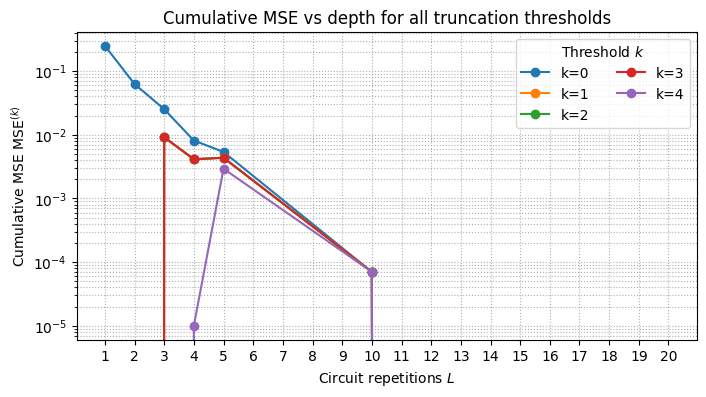

In [10]:
# —— cumulative MSE vs circuit repetitions for all kk from 0 to max_kk —— 
plt.figure(figsize=(8, 4))
for kk in range(0,5):
    ys = mc_results_dict['MSE'][f"{kk}"]   # list of length len(L_vals)
    plt.plot(L_vals, ys, marker='o', label=f'k={kk}')
plt.yscale('log')
plt.xticks(range(min(L_vals), max(L_vals)+1, 1))  # Ensure all integers from 1 to 25 are shown on the x-axis
plt.xlabel('Circuit repetitions $L$')
plt.ylabel('Cumulative MSE $\\mathrm{MSE}^{(k)}$')
plt.title('Cumulative MSE vs depth for all truncation thresholds')
plt.legend(title='Threshold $k$', ncol=2)
plt.grid(True, which='both', ls=':')
plt.show()


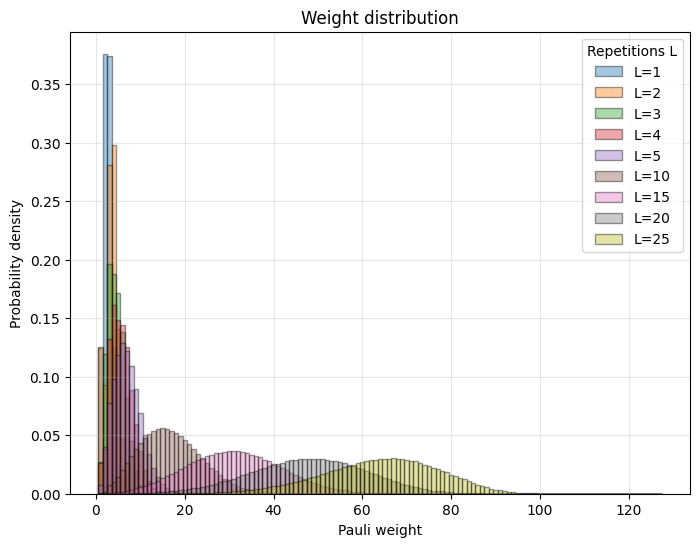

In [8]:
plt.figure(figsize=(8,6))

for L in L_vals:
    entry     = mc_results_dict['weight_hist'][str(L)] 
    hist_vals = entry['hist_vals']    
    bin_edges = entry['bin_edges']   

    widths = [b2 - b1 for b1, b2 in zip(bin_edges[:-1], bin_edges[1:])]

    # bar chart
    plt.bar(bin_edges[:-1], hist_vals, width=widths,
            align='edge', edgecolor='black', alpha=0.4, label=f"L={L}")

plt.xlabel("Pauli weight")
plt.ylabel("Probability density")
plt.title(f"Weight distribution")
plt.legend(title="Repetitions L")
plt.grid(alpha=0.3)
plt.show()
